In [1]:
#Paquetes para modelos
import sciann as sn
import numpy as np
from sciann.utils.math import diff, sign, sin, exp
from sciann.utils import math as scmath

#Paquetes para gráficos

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

---------------------- SCIANN 0.5.5.0 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 



# Ecuación  de la Placa

#### Variables de la ecuación

In [2]:
x = sn.Variable("x") 
y = sn.Variable('y')
t = sn.Variable('t')
u = sn.Functional("u", [x,y,t], 8*[10] ,"tanh")

In [3]:
#Función de activación para los bordes

def activacion(coord,location,direction):
    return (1-sign(direction*(location-coord)))/2

#### Constantes

In [4]:
TOL = 0.05 # Esta constante se usa para que los bordes tomen valores y se activen las funciones de contorno
conveccion = 25 # Coeficiente de pérdida de calor en los bordes y=1 e y=-1
conductividad = 10 # Capacidad conductora de calor del material de la placa
capCal = 1 # Capacidad de retención de calor del material de la placa
focoTemp = 100 # Temperatura del foco de calor
tempExt = 5 # Temperatura del exterior
tempInicial = 0 # Temperatura inicial de la placa

#### Ecuación del calor

In [5]:
#Este funcional explica el flujo del calor a lo largo de la placa (2 dimensiones)
L1 = capCal*diff(u,t) - conductividad *( (diff(u,x,order=2) + diff(u,y,order=2)))

#### Otras ecuaciones

In [6]:
# Este funcional es la condición de que la temperatura inicial sea tempInicial
T0 = activacion(t,TOL,-1)*(u-tempInicial)

#Estos dos funcionales describen la pérdida de calor en los bordes superior e inferior
L2 = activacion(y, 1-TOL, 1) *( conductividad*diff(u,y)- conveccion*(u-tempExt))
L3 = activacion(y,-1+TOL,-1) *(-conductividad*diff(u,y)- conveccion*(u-tempExt))

#Estos dos funcionales describen el aislamiento (pérdida de calor nula) en los bordes laterales
L4 = activacion(x,1-TOL,1)*conductividad*( diff(u,x))
L5 = activacion(x,-1+TOL,-1)*conductividad*(-diff(u,x))

#Este funcional describe el flujo del calor a través de la placa, incluyendo el foco de calor en este caso
F1 = L1 - activacion(t,0.5,1)*(focoTemp * exp(-(x**2+y**2)/(2*(0.5)**2))/(2*np.pi*0.5*0.5))

# Construcción del modelo

In [7]:
m = sn . SciModel ([x,y,t], [F1, L2, L3, L4, L5,T0],"mse","Adam")

#### Mallado del problema

In [8]:
denspt = 10 # Densidad de puntos de evaluación de los funcionales
xmin,ymin,xmax,ymax=-1,-1,1,1 # Límites en x e y
tmin,tmax=0,2 # Límites en tiempo t
xrange,yrange=xmax-xmin,ymax-ymin
trange=tmax-tmin

# Mallado (es una malla en tres dimensiones)
x_data, y_data, t_data = np.meshgrid(
    np.linspace(xmin, xmax, xrange*denspt), 
    np.linspace(ymin, ymax, yrange*denspt),
    np.linspace(tmin,tmax,trange*denspt)
)

#### Entrenamiento del modelo

In [27]:
history = m. train (
[ x_data, y_data, t_data],
6*['zeros'],
 epochs =300,verbose=0,stop_loss_value=0.001
)


Epoch 00068: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00118: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00208: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00258: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


# Gráficos del modelo resultante

#### Mallado para test

In [29]:
densptTest = 10 # Densidad de puntos de evaluación de los funcionales
xminT,yminT,xmaxT,ymaxT=-1,-1,1,1 # Límites en x e y
tminT,tmaxT=0,2 # Límites en tiempo t
xrangeT,yrangeT=xmaxT-xminT,ymaxT-yminT
trangeT=tmaxT-tminT


x_test, y_test, t_test = np.meshgrid(
    np.linspace(xminT, xmaxT, xrangeT*densptTest*10), 
    np.linspace(yminT, ymaxT, yrangeT*densptTest*10),
    np.linspace(0,10,trangeT*densptTest*10)
)
u_pred = u.eval(m,[x_test,y_test,t_test])


#### Gráfico en 2D coloreado

<ipython-input-31-a7220f434669>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_test[:,:,1], y_test[:,:,1], u_pred[:,:,round((tiempoMostrado-tmin)*densptTest*10)],


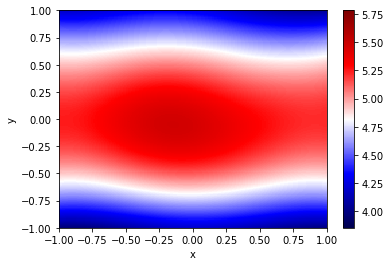

In [31]:
tiempoMostrado = 0.1 #Aquí se elige el segundo a mostrar

fig=plt.plot()
plt.pcolor(x_test[:,:,1], y_test[:,:,1], u_pred[:,:,round((tiempoMostrado-tmin)*densptTest*10)], 
           cmap='seismic',vmin=u_pred.min(),vmax=u_pred.max())
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

#### Gráfico en 3D coloreado

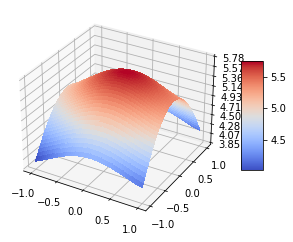

In [40]:
tiempoMostrado = 1 #Aquí se elige el segundo a mostrar

fig=plt.figure()
ax = fig.gca(projection='3d')

X = x_test[:,:,0]
Y = y_test[:,:,0]
Z = u_pred[:,:,round((tiempoMostrado-tmin)*densptTest*10)]


surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False )

# Customize the z axis.
ax.set_zlim(u_pred.min(), u_pred.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()